In [2]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import os
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_89520/2544869563.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# check version number
import imblearn
print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import confusion_matrix
import itertools

imblearn version:  0.12.0


In [8]:
binding_path = 'data/NEK_data_4Berkeley/NEK2/'
nek2_binding_random_imbalanced = 'NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv'
all_fold_df_binding = pd.read_csv(binding_path+nek2_binding_random_imbalanced)
all_fold_df_binding
# this df has shape (1408,310)

,compound_id,base_rdkit_smiles,active,ASA+_per_atom,ASA-,ASA_H_per_atom,ASA_P,ASA_per_atom,BCUT_PEOE_0,BCUT_PEOE_1,...,vsurf_Wp3,vsurf_Wp4,vsurf_Wp5,vsurf_Wp6,vsurf_Wp7,vsurf_Wp8,weinerPath,weinerPol_per_atom,zagreb_per_atom,fold
0,kdb_2562,Cn1cnc2c(N)ncnc21,0,14.897949,53.326256,8.903966,161.217960,17.860519,-2.222484,-0.418766,...,95.250,30.125,12.500,3.750,0.250,0.0,137,0.833333,3.222222,fold4
1,kdb_2536,FC(F)(F)c1ccc(/C=C/c2cncnc2Nc2ccc3[nH]c(Cc4ccc...,0,6.511466,299.143010,8.385662,196.062190,11.950429,-2.311277,-0.649332,...,141.125,30.125,12.250,2.875,0.000,0.0,4495,0.945455,3.418182,fold1
2,kdb_3056,CNCc1ccc(-c2cc(-c3nc(-c4ccc(S(=O)(=O)C(C)C)cc4...,0,8.496225,275.100830,8.517174,278.048280,13.229856,-2.568112,-0.618748,...,231.750,54.000,20.250,4.625,0.125,0.0,3645,0.932203,2.983051,fold2
3,kdb_3510,CNC(=O)Nc1ccc2c(c1)CC[C@@]21OC(=O)N(CC(=O)N(Cc...,0,6.791036,344.713500,8.136228,261.311580,12.350931,-2.586196,-0.562002,...,113.875,27.125,10.625,2.500,0.000,0.0,4847,1.064516,3.322581,fold4
4,kdb_3024,CCCNc1ccc2ncc(-c3ccnc(C)c3)n2n1,0,9.173611,133.466250,9.677048,114.335650,12.685881,-2.513905,-0.540779,...,96.250,22.875,7.500,0.750,0.000,0.0,828,0.763158,2.736842,fold1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403,kdb_2740,COc1cc(Nc2nccc(-c3c(-c4cccc(NC(=O)c5c(F)cccc5F...,1,6.830101,267.095760,9.351566,88.071762,10.592014,-2.333702,-0.641136,...,136.875,26.000,8.000,2.750,0.375,0.0,7766,1.112676,3.408451,fold5
1404,kdb_2211,C[C@@H](Oc1cc(-n2cnc3ccc(OC4CCN(C)CC4)cc32)sc1...,1,7.582028,226.900190,8.290327,182.277340,11.183618,-2.786322,-0.552139,...,174.125,37.375,12.250,2.375,0.125,0.0,4014,0.888889,3.015873,fold5
1405,kdb_2887,Cc1ccc(CC(=O)N2CCc3cc(-c4cn(C)c5ncnc(N)c45)ccc...,1,7.708636,180.384670,8.409422,144.357180,11.133142,-2.448838,-0.593953,...,117.250,24.875,8.750,2.000,0.000,0.0,2628,0.962264,3.169811,fold3
1406,kdb_2768,CNC(=O)c1ccccc1Nc1nc(Nc2ccc(N3CCOCC3)cc2)ncc1Cl,1,7.843355,171.712430,8.605889,130.535580,11.023215,-2.665598,-0.627511,...,183.000,51.250,19.625,5.625,0.125,0.0,3068,0.888889,2.962963,fold1


In [5]:
#inhibition
inhibition_path = 'data/NEK_data_4Berkeley/NEK2/'
inhibition_moe = 'NEK2_1_uM_min_50_pct_inhibition_5fold_random_imbalanced.csv'
all_fold_df_inhibition = pd.read_csv(inhibition_path+inhibition_moe)
all_fold_df_inhibition 

,compound_id,base_rdkit_smiles,active,ASA+_per_atom,ASA-,ASA_H_per_atom,ASA_P,ASA_per_atom,BCUT_PEOE_0,BCUT_PEOE_1,...,vsurf_Wp3,vsurf_Wp4,vsurf_Wp5,vsurf_Wp6,vsurf_Wp7,vsurf_Wp8,weinerPath,weinerPol_per_atom,zagreb_per_atom,fold
0,kdb_952,O=C1NCCc2[nH]c(-c3ccncc3)cc21,0,10.828989,121.34690,10.714393,124.44099,15.323319,-2.513579,-0.604552,...,104.000,29.125,11.500,3.375,0.000,0.0,426,0.851852,3.185185,fold4
1,kdb_704,CN(C)CC1CN(c2ccc3nc(-c4n[nH]c5ccc([N+](=O)[O-]...,0,7.934616,158.87631,7.420585,189.45982,10.865310,-2.743183,-0.533248,...,163.375,31.750,11.375,3.125,0.125,0.0,2905,0.909091,3.127273,fold1
2,kdb_1416,CC(C)Cc1nc(Nc2ccc(N3CCOCC3)c(Cl)c2)nc2[nH]ccc12,0,8.484605,202.84538,9.316943,162.70578,12.507252,-2.663910,-0.574060,...,145.000,33.500,12.500,3.875,0.000,0.0,1989,0.803922,2.823529,fold2
3,kdb_3103,O=C([O-])c1ccc(Oc2nccc(-c3c(-c4ccc(F)cc4)ncn3C...,0,6.847276,246.11134,8.917394,130.18471,11.242121,-2.754876,-0.641494,...,130.625,18.500,6.375,0.875,0.000,0.0,3565,0.964286,3.250000,fold4
4,kdb_1609,CN(C)S(=O)(=O)c1ccccc1-c1ccc2c(c1)Nc1ccccc1NC2=O,0,7.463830,237.68829,10.271510,108.22626,12.574197,-2.524593,-0.529721,...,131.750,35.625,15.250,4.750,0.375,0.0,1925,1.148936,3.276596,fold1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039,kdb_3729,COc1cc(N2CCNCC2)ccc1Nc1ncc(Cl)c(Nc2cccc(OCc3cc...,1,6.803084,250.57068,8.309640,148.12486,10.487947,-2.727067,-0.673099,...,212.375,46.750,16.625,4.250,0.000,0.0,6127,0.955882,3.058824,fold5
2040,kdb_1037,Cc1cccc(NC(=O)Nc2ccc(-c3csc4ncnc(N)c34)cc2)c1,1,7.264791,196.14305,7.586167,182.00252,11.722588,-2.342211,-0.624804,...,194.250,52.250,20.500,6.000,0.375,0.0,2124,0.931818,3.272727,fold3
2041,kdb_3767,COc1cc(N2CCN(C)CC2)ccc1Nc1ncc2c(n1)N1c3ccccc3C...,1,9.273098,136.72115,9.210555,140.78642,11.376500,-2.771752,-0.532007,...,161.375,23.000,7.000,1.375,0.000,0.0,3861,1.000000,3.046154,fold1
2042,kdb_3196,C[C@@H](Oc1cc(-n2cnc3ccc(OCC4CCN(C)CC4)cc32)sc...,1,7.466881,267.99036,8.378218,207.84203,11.527340,-2.812550,-0.552125,...,202.375,41.625,14.125,3.375,0.250,0.0,4452,0.863636,2.939394,fold5


In [12]:
combined_df = pd.concat([all_fold_df_binding, all_fold_df_inhibition ])
value_counts = combined_df[('compound_id')].value_counts()
value_counts
in_both = value_counts[value_counts==2]
in_both

compound_id
kdb_244     2
kdb_2207    2
kdb_1514    2
kdb_1003    2
kdb_1649    2
           ..
kdb_67      2
kdb_123     2
kdb_114     2
kdb_2206    2
kdb_2221    2
Name: count, Length: 112, dtype: int64

In [6]:
# from sklearn 0.19.2 documentation:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
data_path = 'data/datasets/scaled_descriptors/'
binding_file = 'NEK2_1_uM_min_50_pct_binding_with_moe_descriptors.csv'
binding_df = pd.read_csv('data/datasets/scaled_descriptors/NEK2_1_uM_min_50_pct_binding_with_moe_descriptors.csv')
# print(binding_df.shape)
moe_columns = binding_df.columns[3:]
# moe_columns

In [7]:
list(moe_columns)

['ASA+_per_atom',
 'ASA-',
 'ASA_H_per_atom',
 'ASA_P',
 'ASA_per_atom',
 'BCUT_PEOE_0',
 'BCUT_PEOE_1',
 'BCUT_PEOE_2',
 'BCUT_PEOE_3',
 'BCUT_SLOGP_0_per_atom',
 'BCUT_SLOGP_1',
 'BCUT_SLOGP_2',
 'BCUT_SLOGP_3',
 'BCUT_SMR_0_per_atom',
 'BCUT_SMR_1',
 'BCUT_SMR_2',
 'BCUT_SMR_3_per_atom',
 'CASA+_per_atom',
 'CASA-_per_atom',
 'DASA_per_atom',
 'DCASA_per_atom',
 'FASA+',
 'FASA-',
 'FASA_H',
 'FASA_P',
 'FCASA+_per_atom',
 'FCASA-',
 'FCharge',
 'GCUT_PEOE_0',
 'GCUT_PEOE_1',
 'GCUT_PEOE_2',
 'GCUT_PEOE_3',
 'GCUT_SLOGP_0',
 'GCUT_SLOGP_1',
 'GCUT_SLOGP_2',
 'GCUT_SLOGP_3_per_atom',
 'GCUT_SMR_0',
 'GCUT_SMR_1',
 'GCUT_SMR_2',
 'GCUT_SMR_3_per_atom',
 'Kier1_per_atom',
 'Kier2_per_atom',
 'Kier3_per_atom',
 'KierA1_per_atom',
 'KierA2_per_atom',
 'KierA3_per_atom',
 'KierFlex_per_atom',
 'PC+_per_atom',
 'PC-_per_atom',
 'PEOE_PC+',
 'PEOE_PC-_per_atom',
 'PEOE_RPC+',
 'PEOE_RPC-_per_atom',
 'PEOE_VSA+0_per_atom',
 'PEOE_VSA+1_per_atom',
 'PEOE_VSA+2',
 'PEOE_VSA+3',
 'PEOE_VSA+4',


In [1]:
inhibition_df = pd.read_csv('data/NEK_data_4Berkeley/NEK2/NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv') 
inhibition_df.shape

NameError: name 'pd' is not defined

In [18]:
split_path = 'NEK_data_4Berkeley/NEK2/'
random_binding_file = 'NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv'
random_binding_df = pd.read_csv('data/NEK_data_4Berkeley/NEK2/NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv')

In [10]:
print(random_binding_df['fold'].unique())
print(random_binding_df['fold'].value_counts())
print(random_binding_df.columns)

['fold4' 'fold1' 'fold2' 'fold3' 'fold5']
fold
fold1    283
fold2    282
fold4    281
fold3    281
fold5    281
Name: count, dtype: int64
Index(['compound_id', 'base_rdkit_smiles', 'active', 'ASA+_per_atom', 'ASA-',
       'ASA_H_per_atom', 'ASA_P', 'ASA_per_atom', 'BCUT_PEOE_0', 'BCUT_PEOE_1',
       ...
       'vsurf_Wp3', 'vsurf_Wp4', 'vsurf_Wp5', 'vsurf_Wp6', 'vsurf_Wp7',
       'vsurf_Wp8', 'weinerPath', 'weinerPol_per_atom', 'zagreb_per_atom',
       'fold'],
      dtype='object', length=310)


In [11]:
test_random_binding_df = random_binding_df.loc[random_binding_df['fold'] == "fold1"]
train_random_binding_df = random_binding_df.loc[random_binding_df['fold'] != "fold1"]
print(test_random_binding_df.shape)
print(train_random_binding_df.shape)

(283, 310)
(1125, 310)


In [13]:
# test_x_df = test_random_binding_df[moe_columns]
# test_y_df = test_random_binding_df['active']
# train_x_df = train_random_binding_df[moe_columns]
# train_y_df = train_random_binding_df['active']

# print(train_y_df.value_counts()), print(test_y_df.value_counts())


active
0    1080
1      45
Name: count, dtype: int64
active
0    271
1     12
Name: count, dtype: int64


(None, None)

In [25]:
uq_path = 'data/NEK_data_4Berkeley/NEK2/'
train_x_df = pd.read_csv(uq_path+'NEK2_binding_random_fold1_trainX.csv')
train_y_df= pd.read_csv(uq_path+"/NEK2_binding_random_fold1_trainY.csv")
test_x_df= pd.read_csv(uq_path+"/NEK2_binding_random_fold1_testX.csv")
test_y_df= pd.read_csv(uq_path+"/NEK2_binding_random_fold1_testY.csv")
print(train_y_df.value_counts()), print(test_y_df.value_counts())
print(train_y_df.shape, test_y_df.shape)

active
0         1080
1           45
Name: count, dtype: int64
active
0         271
1          12
Name: count, dtype: int64
(1125, 1) (283, 1)


In [21]:
x_df = pd.concat([train_x_df, test_x_df])

scaling=StandardScaler()

scaling.fit(x_df)
Scaled_data=scaling.transform(x_df)
train_scaled_data = scaling.transform(train_x_df)
test_scaled_data = scaling.transform(test_x_df) 
    
# Set the n_components=3
# 95% variance 
principal=PCA(n_components=0.95) 
principal.fit(Scaled_data)
pca_train_x_df=principal.transform(train_scaled_data)
pca_test_x_df=principal.transform(test_scaled_data)

print(pca_train_x_df.shape)
print(pca_test_x_df.shape)

(1125, 67)
(283, 67)


In [33]:
# SMOTE

# SMOTE: Adjust imbalanced training data

# transform the dataset
oversample = SMOTE()
# SMOTE: creating synthetic examples of minority class 
new_train_x_df, new_train_y_df = oversample.fit_resample(pca_train_x_df, train_y_df)

In [40]:
#  Transform data to PyTorch tensors

# PCA then SMOTE
train_x_temp = new_train_x_df.astype("long")
train_y_temp = new_train_y_df.to_numpy().astype("long")

# PCA
test_x_temp = pca_test_x_df.astype("long")


test_y_temp = test_y_df.to_numpy().astype("long")

train_x = torch.from_numpy(train_x_temp)
train_y = torch.from_numpy(train_y_temp.reshape(-1))
test_x = torch.from_numpy(test_x_temp)
test_y = torch.from_numpy(test_y_temp.reshape(-1))

print(train_x.shape)
print(train_y.shape)


torch.Size([2160, 67])
torch.Size([2160])


In [41]:
# Construct a GP classification model

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)


In [42]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 300


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

Iter 1/300 - Loss: 6.985   lengthscale: 0.693   noise: 0.693
Iter 6/300 - Loss: 6.198   lengthscale: 0.973   noise: 0.971
Iter 11/300 - Loss: 5.606   lengthscale: 1.318   noise: 1.272
Iter 16/300 - Loss: 5.160   lengthscale: 1.726   noise: 1.520
Iter 21/300 - Loss: 4.841   lengthscale: 2.190   noise: 1.644
Iter 26/300 - Loss: 4.607   lengthscale: 2.685   noise: 1.632
Iter 31/300 - Loss: 4.420   lengthscale: 3.184   noise: 1.504
Iter 36/300 - Loss: 4.240   lengthscale: 3.674   noise: 1.292
Iter 41/300 - Loss: 4.071   lengthscale: 4.147   noise: 1.033
Iter 46/300 - Loss: 3.924   lengthscale: 4.589   noise: 0.767
Iter 51/300 - Loss: 3.800   lengthscale: 4.982   noise: 0.531
Iter 56/300 - Loss: 3.706   lengthscale: 5.315   noise: 0.348
Iter 61/300 - Loss: 3.640   lengthscale: 5.586   noise: 0.224
Iter 66/300 - Loss: 3.596   lengthscale: 5.803   noise: 0.148
Iter 71/300 - Loss: 3.545   lengthscale: 5.973   noise: 0.103
Iter 76/300 - Loss: 3.526   lengthscale: 6.103   noise: 0.076
Iter 81/30

In [44]:
# Make predictions with the model

model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(train_x)
    pred_means = test_dist.loc
    observed_pred = likelihood(model(train_x))
    
print(pred_means.numpy().shape)
print(pred_means.max(0)[1])

/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


(2, 2160)
tensor([0, 0, 0,  ..., 1, 1, 1])


Confusion matrix, without normalization
[[1079    1]
 [   0 1080]]


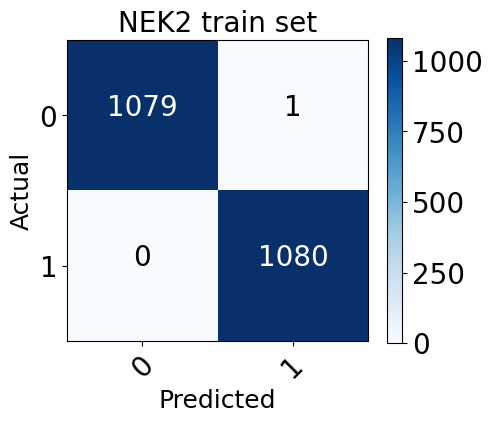

In [45]:
train_prediction = model(train_x).loc.max(0)[1].numpy()
y_true = new_train_y_df.values
y_pred = train_prediction
train_cm = confusion_matrix(y_true, y_pred)
class_names = ["0","1"]

plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit
ax = plt.figure(figsize=(5,5))
plt.title("NEK2 train set",fontsize=20)
plot_confusion_matrix(train_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);


In [60]:
2160
1080+1079

2159

In [46]:
# Make predictions with the model

model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x)
    pred_means = test_dist.loc
    observed_pred = likelihood(model(test_x))
    
print(pred_means.numpy().shape)
print(pred_means.max(0)[1])

(2, 283)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1])


In [47]:
test_prediction = model(test_x).loc.max(0)[1].numpy()
print(test_prediction.shape)
test_prediction

(283,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1])

Confusion matrix, without normalization
[[267   4]
 [  8   4]]


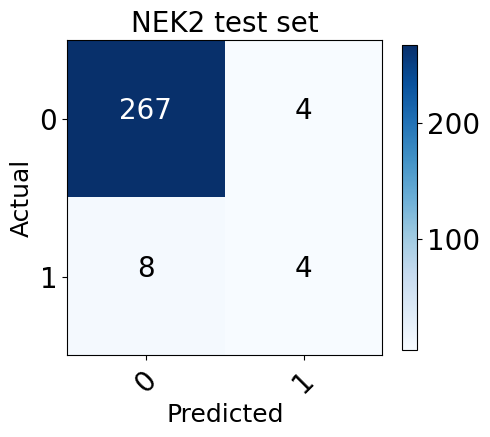

In [48]:
y_true = test_y_df.values
y_pred = test_prediction
test_cm = confusion_matrix(y_true, y_pred)
class_names = ["0","1"]

plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit
ax = plt.figure(figsize=(5,5))
plt.title("NEK2 test set",fontsize=20)
plot_confusion_matrix(test_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);


In [49]:
lower, upper = observed_pred.confidence_region()
upper

tensor([[ 1.6192,  2.0518,  2.4082,  2.4891,  2.5616,  2.7495,  2.3851,  1.8325,
          0.5178,  2.4653,  2.0062,  2.4496,  2.4181,  2.3798,  1.6928,  2.4622,
          2.6471,  2.2017,  1.8500,  2.4258,  2.3360,  1.7500,  1.9023,  2.5967,
          2.4469, -0.7661,  1.9623,  2.2489,  2.0348,  0.6886,  1.7655,  2.5280,
          2.1006,  2.3723,  2.0869,  2.6296,  1.9996,  2.3280,  2.4758,  1.8024,
          1.3067,  2.2958,  2.1173,  2.4486,  2.2611,  1.4840,  2.2214,  1.9604,
          2.4299,  2.3978,  0.7994,  2.3445,  2.2592,  1.7913,  2.1687,  2.4605,
          2.0511,  1.4356,  2.2442,  2.4586,  2.0541,  2.4395,  2.2900,  2.0353,
          1.5976,  2.3124,  2.3662,  2.5016,  1.9713,  2.3646,  1.0045,  2.4044,
          2.4534,  2.2673,  0.7945,  1.9466,  1.9951,  2.4619,  2.2897,  2.1979,
          1.7994,  2.3707,  1.9453, -1.4492,  2.0175,  2.3685,  2.4848,  2.3510,
          0.8899,  2.2476,  2.3272,  2.3156,  0.7940,  2.4199,  2.3399,  2.0728,
          1.9017,  2.1823,  

In [50]:
observed_pred.mean.numpy()

array([[-0.9169748 , -0.5756091 , -0.21670736, -0.14453351, -0.03793894,
         0.12064491, -0.26215255, -0.27261207, -2.0240126 , -0.17729658,
        -0.62531304, -0.16721712, -0.22953194, -0.24977061, -0.5022064 ,
        -0.1861976 ,  0.11359809, -0.40554768, -0.70184475, -0.08476047,
        -0.31048822, -0.85477   , -0.29287755,  0.0085278 , -0.1815524 ,
        -3.0792677 , -0.34130108, -0.39413178, -0.48102874, -1.7276139 ,
        -0.7222028 , -0.04087542, -0.52156717, -0.25462225, -0.5421943 ,
        -0.00970979, -0.40997577, -0.3198937 , -0.16045685, -0.31847334,
        -1.2275294 , -0.3477311 , -0.5171787 , -0.19887912, -0.35638246,
        -1.1158919 , -0.275571  , -0.6679631 , -0.14163278, -0.23312911,
        -1.668069  , -0.27362   , -0.34585458, -0.7251827 , -0.47250813,
        -0.18784893, -0.58436507, -0.63423574, -0.35087955, -0.11766373,
        -0.5401318 , -0.2076764 , -0.3176313 , -0.53450656, -0.7946921 ,
        -0.29704446, -0.27685478, -0.1350393 , -0.6

In [51]:
print(observed_pred.variance.numpy().shape)
observed_pred.variance.numpy()

(2, 283)


array([[1.6080365 , 1.7258031 , 1.722547  , 1.733978  , 1.6894143 ,
        1.7277446 , 1.751997  , 1.1078259 , 1.6152217 , 1.7458154 ,
        1.7311641 , 1.7119017 , 1.7524768 , 1.7287016 , 1.20453   ,
        1.7535381 , 1.6047035 , 1.6994399 , 1.6279547 , 1.575781  ,
        1.7509732 , 1.6962113 , 1.2047267 , 1.6745958 , 1.7271354 ,
        1.3377223 , 1.3266654 , 1.7463734 , 1.5823244 , 1.4594831 ,
        1.5471078 , 1.6497241 , 1.7189528 , 1.7251946 , 1.7280121 ,
        1.7414677 , 1.4515147 , 1.7527758 , 1.7375165 , 1.1245022 ,
        1.6056304 , 1.747114  , 1.7351716 , 1.7522563 , 1.7128606 ,
        1.6899242 , 1.5587143 , 1.7270778 , 1.65323   , 1.7304196 ,
        1.5221274 , 1.7136564 , 1.6965994 , 1.5831627 , 1.7440356 ,
        1.7534902 , 1.7363719 , 1.0710099 , 1.6836554 , 1.6593465 ,
        1.6825418 , 1.7518717 , 1.6999005 , 1.6509863 , 1.4307544 ,
        1.7022696 , 1.7464169 , 1.7379916 , 1.7344978 , 1.6497399 ,
        1.6543621 , 1.7527508 , 1.6762116 , 1.74

In [52]:
print(pred_means.numpy())

[[-0.9169748  -0.5756091  -0.21670736 -0.14453351 -0.03793894  0.12064491
  -0.26215255 -0.27261207 -2.0240126  -0.17729658 -0.62531304 -0.16721712
  -0.22953194 -0.24977061 -0.5022064  -0.1861976   0.11359809 -0.40554768
  -0.70184475 -0.08476047 -0.31048822 -0.85477    -0.29287755  0.0085278
  -0.1815524  -3.0792677  -0.34130108 -0.39413178 -0.48102874 -1.7276139
  -0.7222028  -0.04087542 -0.52156717 -0.25462225 -0.5421943  -0.00970979
  -0.40997577 -0.3198937  -0.16045685 -0.31847334 -1.2275294  -0.3477311
  -0.5171787  -0.19887912 -0.35638246 -1.1158919  -0.275571   -0.6679631
  -0.14163278 -0.23312911 -1.668069   -0.27362    -0.34585458 -0.7251827
  -0.47250813 -0.18784893 -0.58436507 -0.63423574 -0.35087955 -0.11766373
  -0.5401318  -0.2076764  -0.3176313  -0.53450656 -0.7946921  -0.29704446
  -0.27685478 -0.1350393  -0.662708   -0.20421605 -1.5679889  -0.24347693
  -0.13596497 -0.37605068 -1.7571781  -0.6396743  -0.6145855  -0.18657064
  -0.3051371  -0.42728305 -0.7213652  -0.27

In [53]:
pred_samples = test_dist.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
probabilities

tensor([[0.9705, 0.9750, 0.9905, 0.9937, 0.9957, 0.9965, 0.9934, 0.9972, 0.8067,
         0.9953, 0.9674, 0.9953, 0.9883, 0.9944, 0.9920, 0.9925, 0.9979, 0.9909,
         0.9572, 0.9974, 0.9924, 0.9691, 0.9964, 0.9957, 0.9934, 0.5268, 0.9928,
         0.9894, 0.9652, 0.8372, 0.9816, 0.9963, 0.9781, 0.9937, 0.9804, 0.9958,
         0.9932, 0.9894, 0.9917, 0.9969, 0.9224, 0.9927, 0.9779, 0.9933, 0.9929,
         0.9313, 0.9861, 0.9691, 0.9928, 0.9929, 0.8978, 0.9878, 0.9861, 0.9691,
         0.9861, 0.9923, 0.9836, 0.9865, 0.9895, 0.9934, 0.9787, 0.9948, 0.9887,
         0.9671, 0.9691, 0.9923, 0.9924, 0.9955, 0.9774, 0.9948, 0.8743, 0.9929,
         0.9962, 0.9821, 0.8021, 0.9756, 0.9742, 0.9942, 0.9907, 0.9859, 0.9772,
         0.9935, 0.9707, 0.3146, 0.9826, 0.9919, 0.9950, 0.9879, 0.9034, 0.9914,
         0.9937, 0.9813, 0.8405, 0.9935, 0.9868, 0.9798, 0.9793, 0.9876, 0.9894,
         0.9958, 0.9906, 0.9834, 0.9910, 0.9940, 0.9906, 0.9037, 0.7003, 0.9867,
         0.9035, 0.9752, 0.9